**Prior to this I downloaded the kaggle dataset of news articles I am using into my local repo + downloaded and set up spark in my virtual environment -detailed steps in README.md. From here I am starting my spark session and building dataframes composed of various amounts of files**

In [1]:
import os
import time
import re
from pathlib import Path 
from collections import Counter
import pandas as pd
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

Step 1: Create the spark session 

In [2]:
def create_spark_session(app_name="analysis",
                         local_cores=8,
                         shuffle_partitions=16):
    conf = (
        SparkConf()
        .setAppName(app_name)
        .setMaster(f"local[{local_cores}]")
        .set("spark.executor.memory", "4g")
        .set("spark.driver.memory", "4g")
        .set("spark.sql.shuffle.partitions", str(shuffle_partitions))
        .set("spark.sql.adaptive.enabled", "true")
    )
    spark = SparkSession.builder.config(conf=conf).getOrCreate()
    spark.sparkContext.setLogLevel("WARN")
    return spark

spark = create_spark_session(app_name="SocialAnimal_Files_Analysis")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/09/05 14:39:12 WARN Utils: Your hostname, Giselles-MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 10.0.0.60 instead (on interface en0)
25/09/05 14:39:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/05 14:39:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Step 2: I made an array storing all paths to each text file I am processing. I then created 4 datasets each containing 100, 1k, 5k and 9.7k files respectively. 

In [3]:
def file_path_collection(dir):
    all_file_paths = []
    for root, _, files in os.walk(dir):
        for file in files:
            if file.endswith('.txt'):
                all_file_paths.append(os.path.join(root, file))
    return all_file_paths

def datasets_creation(files):
    all_datasets = {}
    for num in [100, 1000, 5000,10000]:
        if num > len(files):
            print(f"Not enough files : {len(files)} included") #10k case -- only 97000 files 
            all_datasets[len(files)] = files
        else:
            all_datasets[num] = files[:num]
    return all_datasets

PATH = "social_animal_data"
files = file_path_collection(PATH)
all_datasets = datasets_creation(files)
print('dataset creation complete')

Not enough files : 9653 included
dataset creation complete


Here I implement a map reduce version of word count: that counts the total occurrences of each word across all files. 

In [4]:
def word_map_gen(path):
    try:
        text = Path(path).read_text(encoding="utf-8", errors="ignore").lower()
        words = re.findall(r'\b[a-zA-Z]{3,}\b', text)
        return list(Counter(words).items()) 
    except Exception as e:
        print(f"file path error {e}")
        return []
        
def mapreduce_wrd_count(spark_session, f_paths, partition):
    t0 = time.time()
    pair_wrds = (spark_session.sparkContext.parallelize(f_paths, partition)).flatMap(word_map_gen)
    wrd_cnts = pair_wrds.reduceByKey(lambda a, b: a + b)
    top_words = wrd_cnts.top(30, key=lambda x: x[1])
    runtime = time.time() - t0
    return runtime, top_words, wrd_cnts.count()

Here I implement a map reduce that calculates the top 30 words occuring in most documents, solving a document frequency problem. 

In [5]:
def word_map_gen_doc_freq(file_path):
    try:
        text = Path(file_path).read_text(encoding="utf-8", errors="ignore").lower()
        unique_words = set(re.findall(r'\b[a-zA-Z]{3,}\b', text))
        return [(word, 1) for word in unique_words]
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return []

def mapreduce_doc_frequency(spark_session, f_paths, partition):
    t0 = time.time()
    word_doc_pairs = (spark_session.sparkContext.parallelize(f_paths, partition).flatMap(word_map_gen_doc_freq))
    doc_frequencies = word_doc_pairs.reduceByKey(lambda a, b: a + b)
    top_words_by_doc_freq = doc_frequencies.top(30, key=lambda x: x[1])
    runtime = time.time() - t0
    
    return runtime, top_words_by_doc_freq, doc_frequencies.count()

Here I implement a map reduce version to calculate the average word frequency per document, this details how often each word on average appears in each file. 

In [6]:
def word_map_gen_avg_freq(file_path):
    try:
        text = Path(file_path).read_text(encoding="utf-8", errors="ignore").lower()
        words = re.findall(r'\b[a-zA-Z]{3,}\b', text)
        word_counts = Counter(words)
        return [(word, (count, 1)) for word, count in word_counts.items()]
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return []

def mapreduce_avg_word_freq(spark_session, f_paths, partition):
    t0 = time.time()
    word_freq_pairs = (spark_session.sparkContext
                      .parallelize(f_paths, partition)
                      .flatMap(word_map_gen_avg_freq))
    word_totals = word_freq_pairs.reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))
    word_averages = word_totals.map(lambda x: (x[0], x[1][0] / x[1][1])) 
    top_words_avg = word_averages.top(30, key=lambda x: x[1])
    runtime = time.time() - t0
    
    return runtime, top_words_avg, word_averages.count()

In [7]:
def map_reduce_analysis():

    results = []
    
    for ds in all_datasets.items():

        name = ds[0]
        list_files = ds[1]

        for p in [2,8, 32]:
            #word count 
            try:
                runtime, high_words, total_words = mapreduce_wrd_count(
                    spark, list_files, p
                )
                results.append({
                    'ds_name': name,
                    'map_reduce_version': 'Word Count Map Reduce',
                    'partitions': p,
                    'rt': runtime,
                    'tot_words_unique': total_words,
                    'high_words': high_words,
                })
            except Exception as e:
                print(f"word count rror: {e}")
            
            #top 30 words printing
            try:
                runtime_doc, high_words_doc, total_words_doc = mapreduce_doc_frequency(
                    spark, list_files, p
                )
                results.append({
                    'ds_name': name,
                    'map_reduce_version': 'Document Frequency',
                    'partitions': p,
                    'rt': runtime_doc,
                    'tot_words_unique': total_words_doc,
                    'high_words': high_words_doc,
                })
                    
            except Exception as e:
                print(f"doc freq error: {e}")
            #average word count 
            try:
                runtime_3, high_words_3, total_words_3 = mapreduce_avg_word_freq(
                    spark, list_files, p
                )
                results.append({
                    'ds_name': name,
                    'map_reduce_version': 'Average Word Frequency Map Reduce',
                    'partitions': p,
                    'rt': runtime_3,
                    'tot_words_unique': total_words_3,
                    'high_words': high_words_3,
                })
            except Exception as e:
                print(f"avg word error: {e}")
    
    return results

In [8]:
analysis_outputs = map_reduce_analysis()
results_df = pd.DataFrame(analysis_outputs)
print("\nPerformance Results:")
print(results_df.to_string())


Performance Results:
    ds_name                 map_reduce_version  partitions        rt  tot_words_unique                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            high_words                                 description
0       100              Word Count Map Reduce           2  0.818430              8517                                                                                                                                              [(the, 3295), (and, 1580), (for, 648), (that, 571), (with, 450), (this, 317), (was, 299), (you, 282),

In [9]:
def analyze_document_frequency_results(results_df):

    doc_freq_results = results_df[results_df['map_reduce_version'] == 'Document Frequency']
    
    for dataset_size in sorted(doc_freq_results['ds_name'].unique()):
        print(f"\n{dataset_size} files")
        
        dataset_results = doc_freq_results[doc_freq_results['ds_name'] == dataset_size]
        best_partition = dataset_results.loc[dataset_results['rt'].idxmin(), 'partitions']
        best_result = dataset_results[dataset_results['partitions'] == best_partition].iloc[0]
        
        for i, (word, doc_count) in enumerate(best_result['high_words'][:30]):
            print(f"  {i+1:2d}. '{word:12s}'appears in {doc_count:4d} of files {dataset_size})")

results = map_reduce_analysis()
results_df = pd.DataFrame(results)
results_df.to_csv("mapreduce_results_file.csv", index=False)

analyze_document_frequency_results(results_df)



Dataset Size: 100 files
----------------------------------------
   1. 'the         ' - appears in   97 files ( 97.0%)
   2. 'and         ' - appears in   93 files ( 93.0%)
   3. 'for         ' - appears in   87 files ( 87.0%)
   4. 'with        ' - appears in   81 files ( 81.0%)
   5. 'that        ' - appears in   78 files ( 78.0%)
   6. 'this        ' - appears in   76 files ( 76.0%)
   7. 'from        ' - appears in   74 files ( 74.0%)
   8. 'have        ' - appears in   70 files ( 70.0%)
   9. 'are         ' - appears in   69 files ( 69.0%)
  10. 'will        ' - appears in   67 files ( 67.0%)
  11. 'was         ' - appears in   65 files ( 65.0%)
  12. 'has         ' - appears in   61 files ( 61.0%)
  13. 'not         ' - appears in   54 files ( 54.0%)
  14. 'all         ' - appears in   54 files ( 54.0%)
  15. 'their       ' - appears in   53 files ( 53.0%)
  16. 'but         ' - appears in   53 files ( 53.0%)
  17. 'one         ' - appears in   53 files ( 53.0%)
  18. 'which    

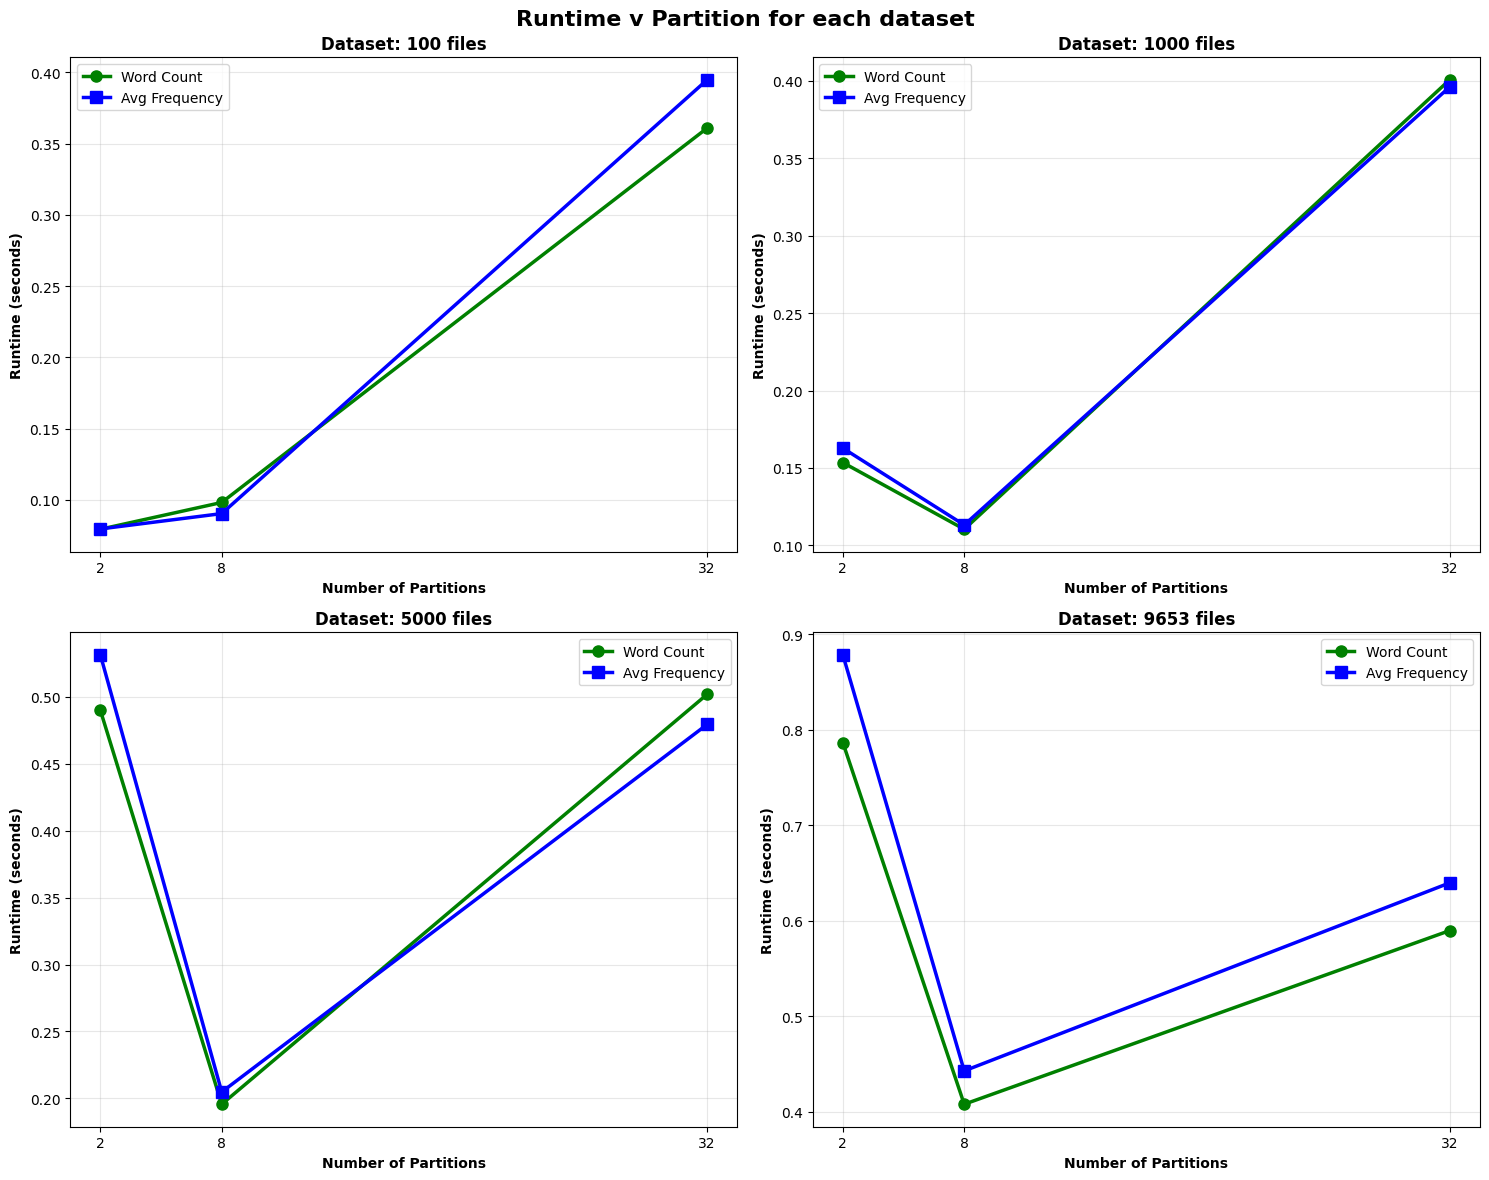

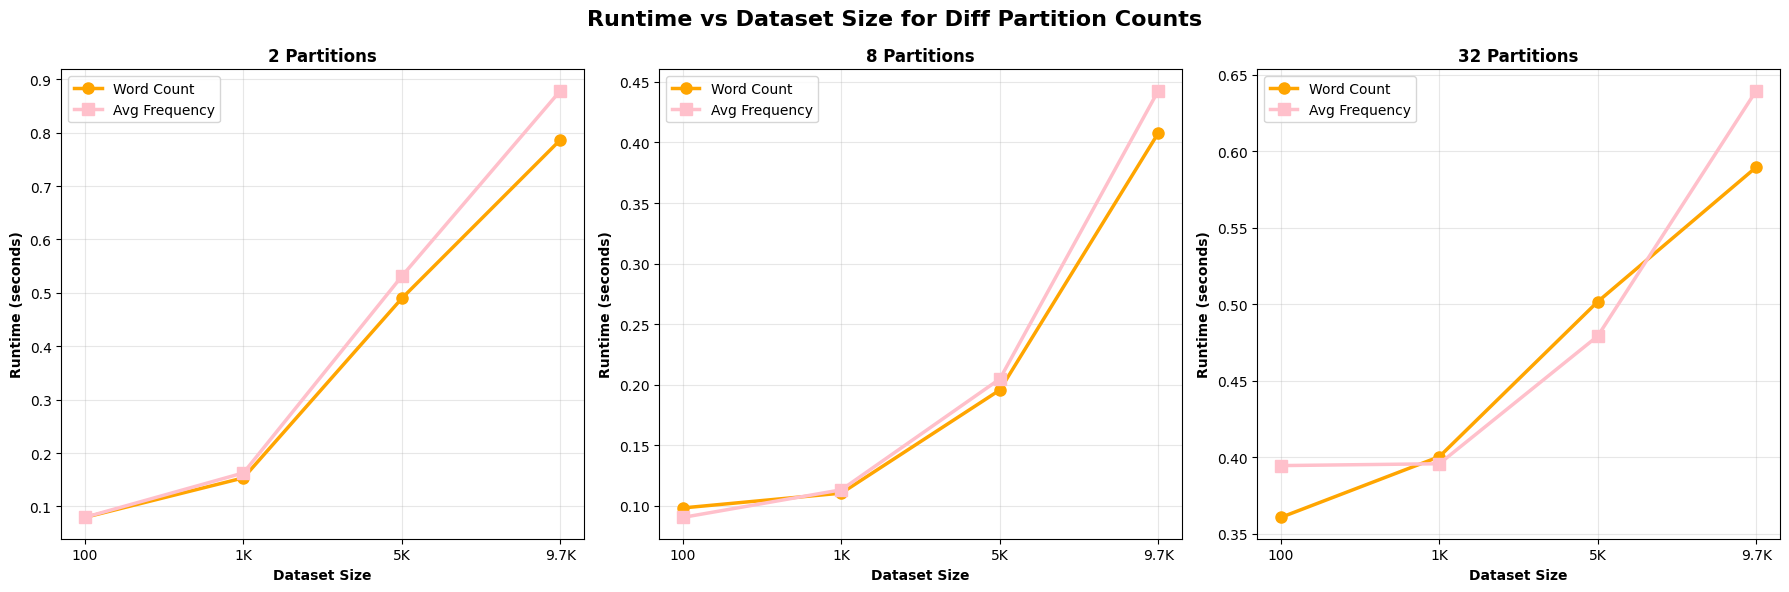

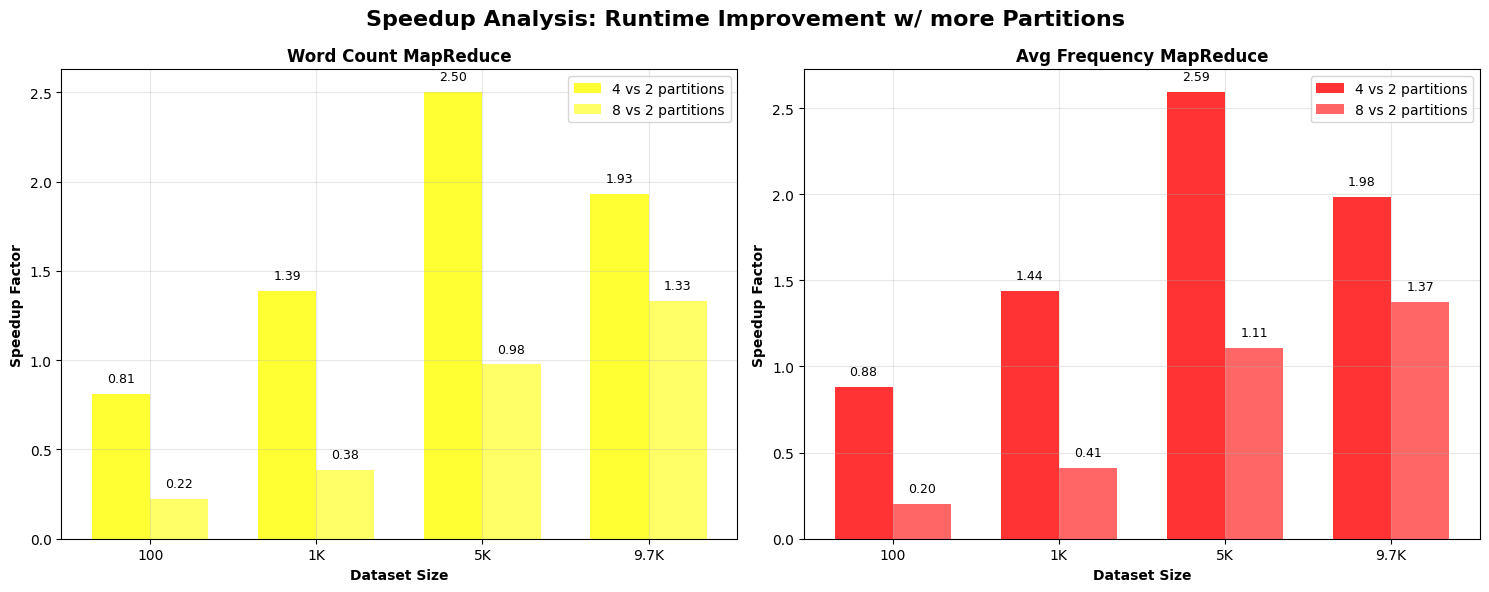

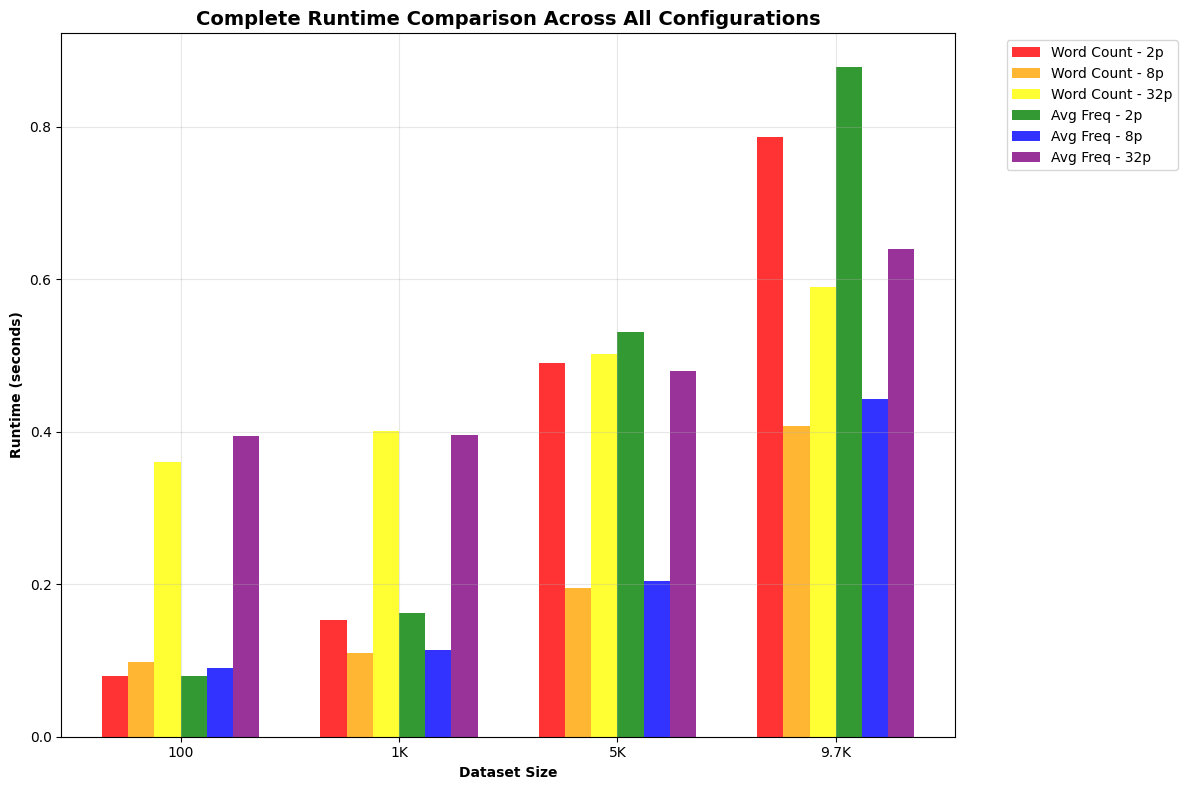

summary
\nDataset Size: 100 files
Word-Count:
  2 partitions: 0.079s
  8 partitions: 0.098s
  32 partitions: 0.361s
Average:
  2 partitions: 0.080s
  8 partitions: 0.090s
  32 partitions: 0.395s
\nDataset Size: 1000 files
Word-Count:
  2 partitions: 0.153s
  8 partitions: 0.110s
  32 partitions: 0.401s
Average:
  2 partitions: 0.163s
  8 partitions: 0.113s
  32 partitions: 0.396s
\nDataset Size: 5000 files
Word-Count:
  2 partitions: 0.490s
  8 partitions: 0.196s
  32 partitions: 0.502s
Average:
  2 partitions: 0.531s
  8 partitions: 0.205s
  32 partitions: 0.479s
\nDataset Size: 9653 files
Word-Count:
  2 partitions: 0.787s
  8 partitions: 0.408s
  32 partitions: 0.590s
Average:
  2 partitions: 0.879s
  8 partitions: 0.443s
  32 partitions: 0.640s


In [14]:
def create_runtime_analysis_graphs(results_df):
    dataset_sizes = [100, 1000, 5000, 9653]
    partitions = [2, 8, 32]
    
    word_count_data = results_df[results_df['map_reduce_version'] == 'Word Count Map Reduce']
    avg_freq_data = results_df[results_df['map_reduce_version'] == 'Average Word Frequency Map Reduce']
    
# graph 1
    fig1, axes1 = plt.subplots(2, 2, figsize=(15, 12))
    fig1.suptitle('Runtime v Partition for each dataset', fontsize=16, fontweight='bold')
    
    axes1 = axes1.flatten()
    
    for i, ds_size in enumerate(dataset_sizes):
        ax = axes1[i]

        wc_subset = word_count_data[word_count_data['ds_name'] == ds_size]
        avg_subset = avg_freq_data[avg_freq_data['ds_name'] == ds_size]
        
        ax.plot(partitions, wc_subset['rt'].values, 'o-', linewidth=2.5, markersize=8, 
                label='Word Count', color='green')
        ax.plot(partitions, avg_subset['rt'].values, 's-', linewidth=2.5, markersize=8, 
                label='Avg Frequency', color='blue')
        
        ax.set_title(f'Dataset: {ds_size} files', fontweight='bold', fontsize=12)
        ax.set_xlabel('Number of Partitions', fontweight='bold')
        ax.set_ylabel('Runtime (seconds)', fontweight='bold')
        ax.set_xticks(partitions)
        ax.grid(True, alpha=0.3)
        ax.legend()
    
    plt.tight_layout()
    plt.savefig('graph1')
    plt.show()
    
# graph 2
    fig2, axes2 = plt.subplots(1, 3, figsize=(18, 6))
    fig2.suptitle('Runtime vs Dataset Size for Diff Partition Counts', fontsize=16, fontweight='bold')
    
    for i, partition_count in enumerate(partitions):
        ax = axes2[i]
        
        wc_runtimes = []
        avg_runtimes = []
        
        for ds_size in dataset_sizes:
            wc_runtime = word_count_data[(word_count_data['ds_name'] == ds_size) & 
                                       (word_count_data['partitions'] == partition_count)]['rt'].iloc[0]
            avg_runtime = avg_freq_data[(avg_freq_data['ds_name'] == ds_size) & 
                                      (avg_freq_data['partitions'] == partition_count)]['rt'].iloc[0]
            wc_runtimes.append(wc_runtime)
            avg_runtimes.append(avg_runtime)
        
        x_labels = ['100', '1K', '5K', '9.7K']
        x_pos = range(len(dataset_sizes))
        
        ax.plot(x_pos, wc_runtimes, 'o-', linewidth=2.5, markersize=8, 
                label='Word Count', color='orange')
        ax.plot(x_pos, avg_runtimes, 's-', linewidth=2.5, markersize=8, 
                label='Avg Frequency', color='pink')
        
        ax.set_title(f'{partition_count} Partitions', fontweight='bold', fontsize=12)
        ax.set_xlabel('Dataset Size', fontweight='bold')
        ax.set_ylabel('Runtime (seconds)', fontweight='bold')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(x_labels)
        ax.grid(True, alpha=0.3)
        ax.legend()
    
    plt.tight_layout()
    plt.savefig('graph2')
    plt.show()

    
# graph 3
    fig5, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    x_pos = np.arange(len(dataset_sizes))
    width = 0.12
    
    colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']
    
    # Plot all combinations
    combinations = [
        (word_count_data, '2 partitions', 2, 'Word Count'),
        (word_count_data, '8 partitions', 8, 'Word Count'),
        (word_count_data, '32 partitions', 32, 'Word Count'),
        (avg_freq_data, '2 partitions', 2, 'Avg Freq'),
        (avg_freq_data, '8 partitions', 8, 'Avg Freq'),
        (avg_freq_data, '32 partitions', 32, 'Avg Freq')
    ]
    
    for i, (data, label, partition_count, algo_type) in enumerate(combinations):
        runtimes = []
        for ds_size in dataset_sizes:
            runtime = data[(data['ds_name'] == ds_size) & 
                         (data['partitions'] == partition_count)]['rt'].iloc[0]
            runtimes.append(runtime)
        
        bars = ax.bar(x_pos + i * width, runtimes, width, 
                     label=f'{algo_type} - {partition_count}p', 
                     color=colors[i], alpha=0.8)
    
    ax.set_title('Complete Runtime Comparison Across All Configurations', 
                fontweight='bold', fontsize=14)
    ax.set_xlabel('Dataset Size', fontweight='bold')
    ax.set_ylabel('Runtime (seconds)', fontweight='bold')
    ax.set_xticks(x_pos + width * 2.5)
    ax.set_xticklabels(['100', '1K', '5K', '9.7K'])
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('graph3')
    plt.show()
    
    print("summary")
    for ds_size in dataset_sizes:
        print(f"\\nDataset Size: {ds_size} files")
        
        wc_data = word_count_data[word_count_data['ds_name'] == ds_size]
        avg_data = avg_freq_data[avg_freq_data['ds_name'] == ds_size]
        
        print("Word-Count:")
        for _, row in wc_data.iterrows():
            print(f"  {row['partitions']} partitions: {row['rt']:.3f}s")
        
        print("Average:")
        for _, row in avg_data.iterrows():
            print(f"  {row['partitions']} partitions: {row['rt']:.3f}s")

create_runtime_analysis_graphs(results_df)

In [ ]:
results_df.to_csv("mapreduce_results.csv", index=False)